In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [3]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
df_train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
df_test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [4]:
df_train.shape

(33126, 8)

In [5]:
df_test.shape

(10982, 5)

**Desciption of valuables**

Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.

1. image name -> the filename of specific image for the train set
2. patient_id -> identifies the unique patient
3. sex -> gender of the patient
4. age_approx -> approx age of the patient at time of scanning
5. anatom_site_general_challenge -> location of the scan site
6. diagnosis -> information about the diagnosis
7. benign_malignant - indicates scan result if it's malignant or benign
8. target -> same as above but better for modelling since it's binary

In [6]:
df_train.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
8,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0


In [7]:
df_test.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
5,ISIC_0074618,IP_4438996,male,50.0,lower extremity
6,ISIC_0076801,IP_3110660,male,45.0,upper extremity
7,ISIC_0077586,IP_8578442,male,50.0,lower extremity
8,ISIC_0082004,IP_0817448,female,45.0,torso
9,ISIC_0082785,IP_3634181,male,65.0,lower extremity


In [8]:
df_train.describe(percentiles=[.1,.25,.50,.75,.95,.99])

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
10%,30.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
95%,70.000000,0.000000
99%,80.000000,1.000000


In [9]:
df_test.describe(percentiles=[.1,.25,.50,.75,.95,.99])

,age_approx
count,10982.000000
mean,49.525587
std,14.370589
min,10.000000
10%,30.000000
25%,40.000000
50%,50.000000
75%,60.000000
95%,75.000000
99%,85.000000


**Checking missing value**

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [13]:
# Missing values statistics
data_trans = df_train
total = data_trans.isnull().sum()
percent = data_trans.isnull().sum()/len(df_train)*100
missing_data = pd.concat([total,percent], axis=1,keys=['Total', 'Percent'])
missing_data

,Total,Percent
image_name,0,0.000000
patient_id,0,0.000000
sex,65,0.196220
age_approx,68,0.205277
anatom_site_general_challenge,527,1.590895
diagnosis,0,0.000000
benign_malignant,0,0.000000
target,0,0.000000


In [14]:
# Missing values statistics
total = df_test.isnull().sum()
percent = df_test.isnull().sum()/len(df_test)*100
missing_data = pd.concat([total,percent], axis=1,keys=['Total', 'Percent'])
missing_data

,Total,Percent
image_name,0,0.000000
patient_id,0,0.000000
sex,0,0.000000
age_approx,0,0.000000
anatom_site_general_challenge,351,3.196139


The anatomy shows most missing values.

Image name

In [15]:
df_train.image_name.value_counts().max()

1

In [16]:
df_test.image_name.value_counts().max()

1

all names are unique.

**Gender**

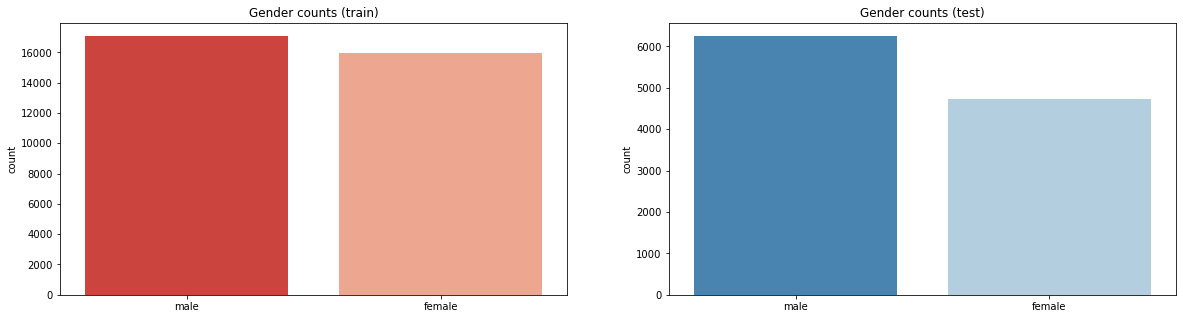

In [17]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(df_train.sex, palette="Reds_r", ax=ax[0]);
ax[0].set_xlabel("")
ax[0].set_title("Gender counts (train)");

sns.countplot(df_test.sex, palette="Blues_r", ax=ax[1]);
ax[1].set_xlabel("")
ax[1].set_title("Gender counts (test)");

*Insights*

- We observe more males than females in both train and test data.
- The surplus of males is even higher in test than in train!

**Age distributions**

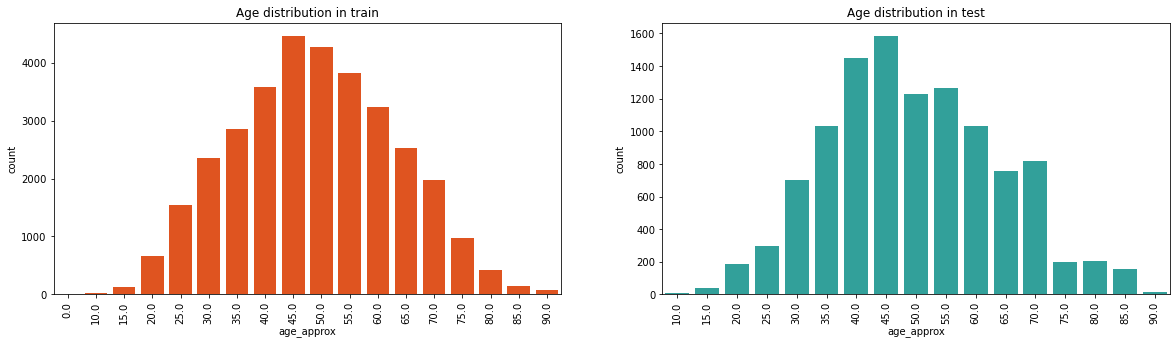

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(df_train.age_approx, color="orangered", ax=ax[0]);
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
# ax[0].set_xlabel("");
ax[0].set_title("Age distribution in train");

sns.countplot(df_test.age_approx, color="lightseagreen", ax=ax[1]);
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
# ax[1].set_xlabel("");
ax[1].set_title("Age distribution in test");

*Insights*

- The age distribution in train looks almost normally distributed.
- In contrast, the age distribution in test shows multiple modes and interesting peaks at the ageof 55 and 70!
- We can observe more older patients in test than in train! This kind of imbalance can be important for our model performance if the age is an important feature.

**Image location**

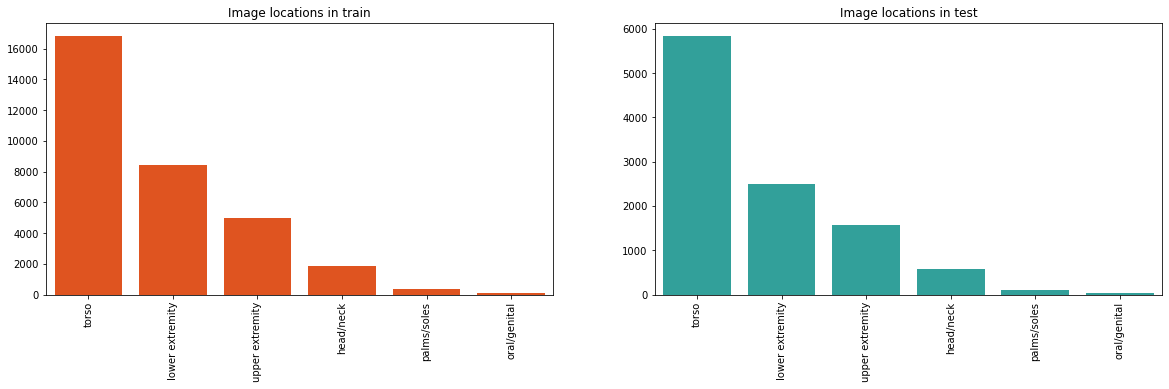

In [19]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

image_locations_train = df_train.anatom_site_general_challenge.value_counts().sort_values(ascending=False)
image_locations_test = df_test.anatom_site_general_challenge.value_counts().sort_values(ascending=False)

sns.barplot(x=image_locations_train.index.values, y=image_locations_train.values, ax=ax[0], color="orangered");
ax[0].set_xlabel("");
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Image locations in train");

sns.barplot(x=image_locations_test.index.values, y=image_locations_test.values, ax=ax[1], color="lightseagreen");
ax[1].set_xlabel("");
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_title("Image locations in test");

*Insights*

- The distributions of image locations in train and test look very similar.
- Most images are related to the torso or to the lower extremity.

**Target distribution**

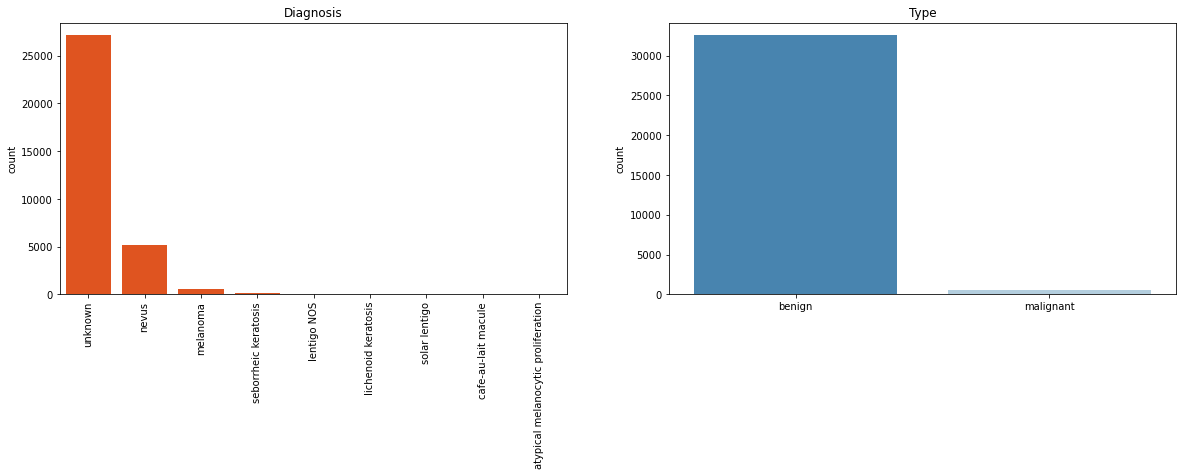

In [20]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

sns.countplot(x=df_train.diagnosis, orient="v", ax=ax[0], color="Orangered")
ax[0].set_xlabel("")
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Diagnosis");

sns.countplot(df_train.benign_malignant, ax=ax[1], palette="Blues_r");
ax[1].set_xlabel("")
ax[1].set_title("Type");

*Insights*

- The diagnosis is often unknown and for those known we observe a very high imbalance. Most likely we can't expect much from this additional target feature.
- The target is highly imbalanced and we have to find proper strategies to deal with this kind of target distribution during learning.

In [21]:
df_train.groupby("benign_malignant").target.nunique()

benign_malignant
benign       1
malignant    1
Name: target, dtype: int64

The benign_malignant column is the same as the target.

# Feature-feature interactions

**Age and gender**

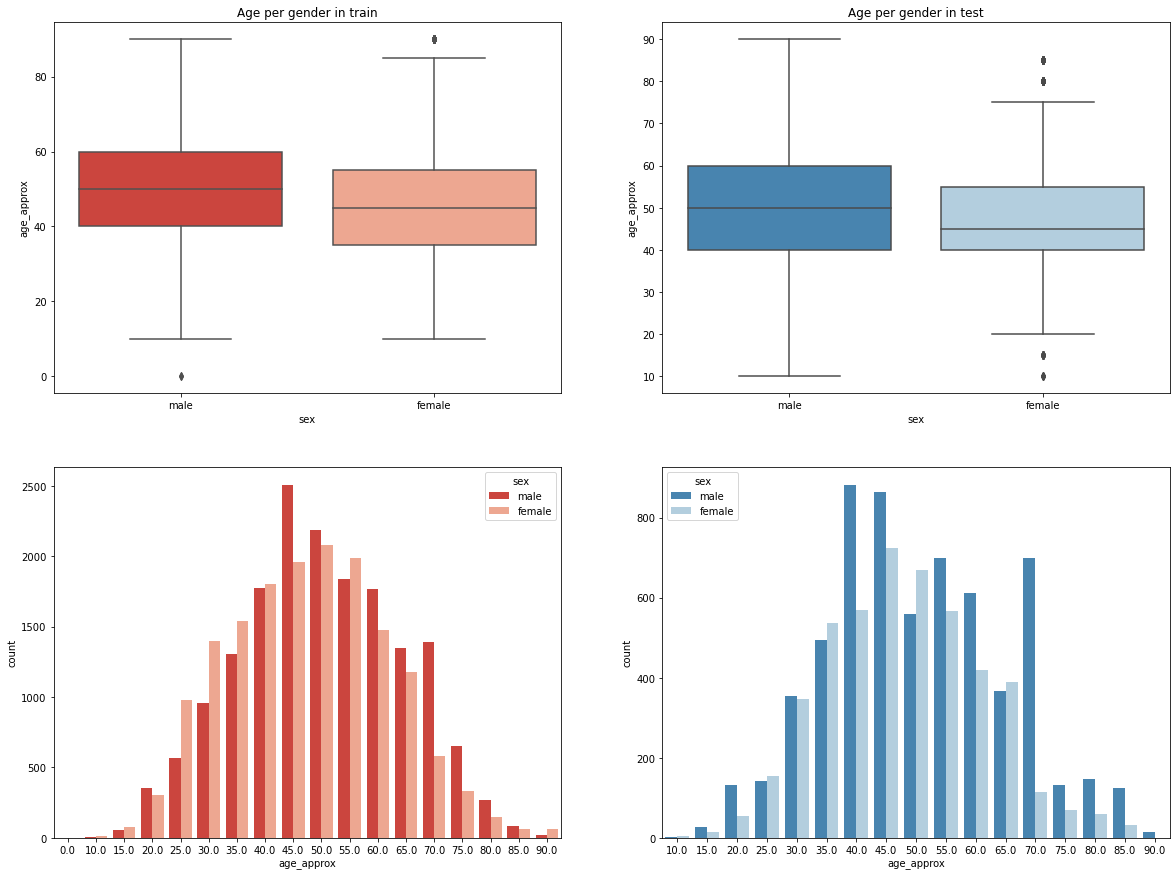

In [22]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.boxplot(df_train.sex, df_train.age_approx, ax=ax[0,0], palette="Reds_r");
ax[0,0].set_title("Age per gender in train");

sns.boxplot(df_test.sex, df_test.age_approx, ax=ax[0,1], palette="Blues_r");
ax[0,1].set_title("Age per gender in test");

sns.countplot(df_train.age_approx, hue=df_train.sex, ax=ax[1,0], palette="Reds_r");
sns.countplot(df_test.age_approx, hue=df_test.sex, ax=ax[1,1], palette="Blues_r");

*Insights*

There are some significant differences in train and test regarding the gender per age level:

- At the ages between 25 and 35 we have much more females than males in train but a balanced count in test!
- We can observe a high surplus of males in the ages 45 to 50 and 70, 75 in train and test but in test we can find even more males of high age > 75.

**Age, gender and cancer**

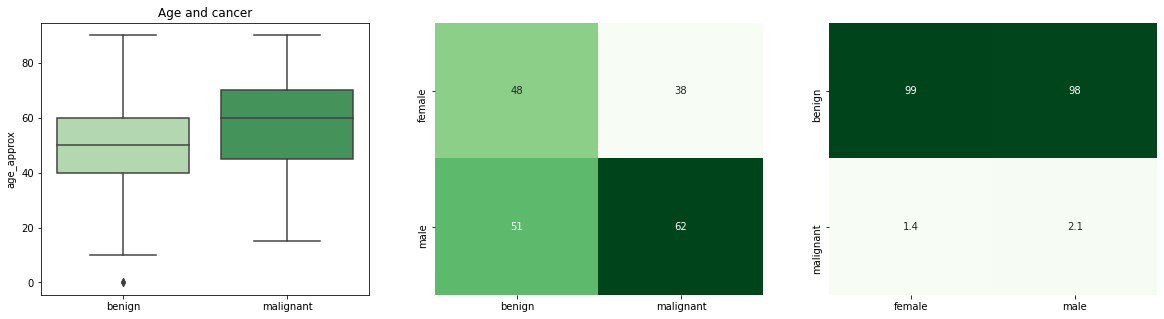

In [23]:
sex_and_cancer_map = df_train.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=0) / df_train.groupby("benign_malignant").size() * 100

cancer_sex_map = df_train.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=1) / df_train.groupby("sex").size() * 100


fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.boxplot(df_train.benign_malignant, df_train.age_approx, ax=ax[0], palette="Greens");
ax[0].set_title("Age and cancer");
ax[0].set_xlabel("");

sns.heatmap(sex_and_cancer_map, annot=True, cmap="Greens", cbar=False, ax=ax[1])
ax[1].set_xlabel("")
ax[1].set_ylabel("");

sns.heatmap(cancer_sex_map, annot=True, cmap="Greens", cbar=False, ax=ax[2])
ax[2].set_xlabel("")
ax[2].set_ylabel("");

*Insights*

- We have more malignant cases of higher age than benign cases.
- 62 % of the malignant cases belong to males and only 38 % to females.
- Roughly 2 % of the males in the train dataset show malignant cases, but only 1.4 % of the females.

We have to be very careful!!! As we have a surpus of males with ages above 70 and 75 it's unclear if the sex is really an important feature for having melanoma or not. It could also be that the age is most important and that we only have more malignant cases for males due to their higher age!

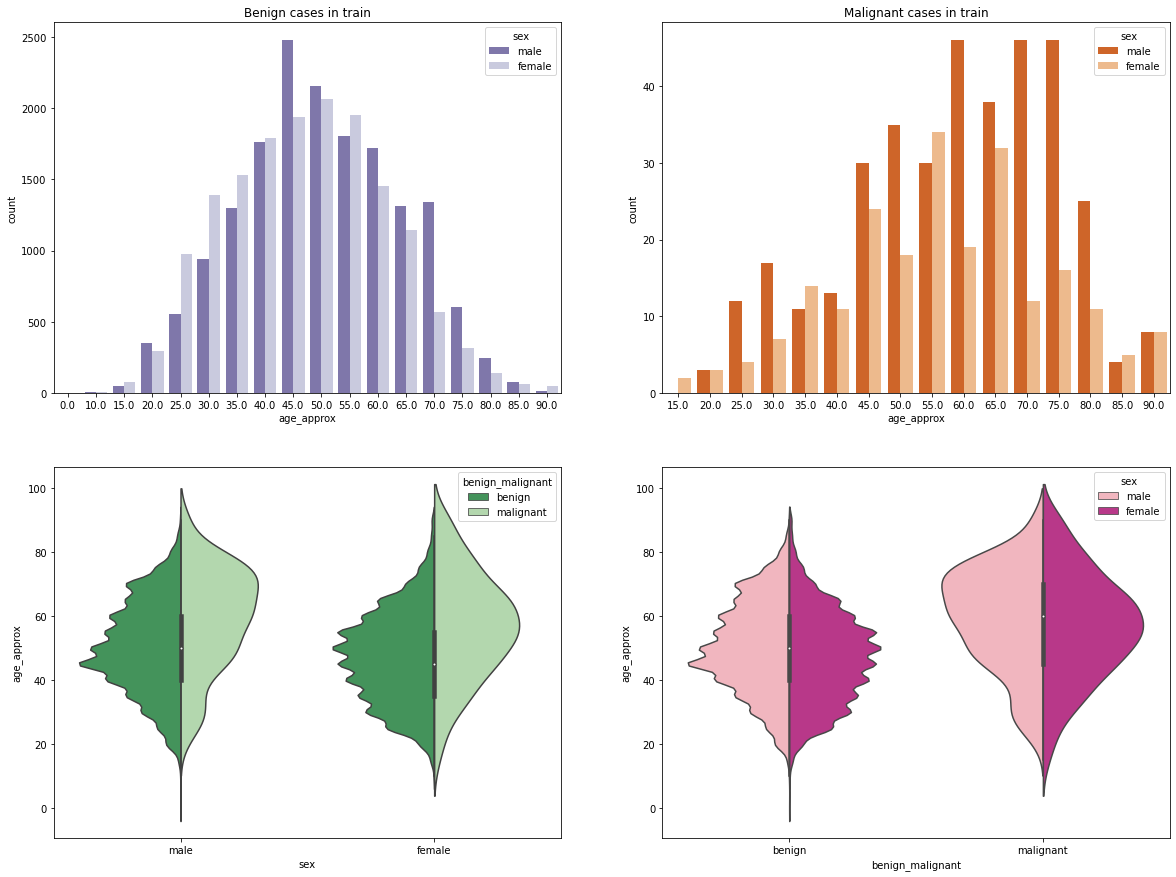

In [24]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.countplot(df_train[df_train.benign_malignant=="benign"].age_approx, hue=df_train.sex, palette="Purples_r", ax=ax[0,0])
ax[0,0].set_title("Benign cases in train");

sns.countplot(df_train[df_train.benign_malignant=="malignant"].age_approx, hue=df_train.sex, palette="Oranges_r", ax=ax[0,1])
ax[0,1].set_title("Malignant cases in train");

sns.violinplot(df_train.sex, df_train.age_approx, hue=df_train.benign_malignant, split=True, ax=ax[1,0], palette="Greens_r");
sns.violinplot(df_train.benign_malignant, df_train.age_approx, hue=df_train.sex, split=True, ax=ax[1,1], palette="RdPu");

*Insights*

- For the benign cases we can see that there is still a surplus of males in the ages of 45 and 70, but the other ones look quite good and balanced.

- In contrast we can find a high gender imbalance for a wide range of ages for the malignant cases! That's really interesting and the features age and gender as well as their interaction with cancer are definitely some to play with during modelling.

**Individual patient information:**

Let's collect some information for each patient:

- the number of recorded images
- the gender
- the min, max age and the age span
- the number of benign & malignant cases
- the minimum and maximum age of a patient with malignant cases

In [25]:
patient_gender_train = df_train.groupby("patient_id").sex.unique().apply(lambda l: l[0])
patient_gender_test = df_test.groupby("patient_id").sex.unique().apply(lambda l: l[0])

train_patients = pd.DataFrame(index=patient_gender_train.index.values, data=patient_gender_train.values, columns=["sex"])
test_patients = pd.DataFrame(index=patient_gender_test.index.values, data=patient_gender_test.values, columns=["sex"])

train_patients.loc[:, "num_images"] = df_train.groupby("patient_id").size()
test_patients.loc[:, "num_images"] = df_test.groupby("patient_id").size()

train_patients.loc[:, "min_age"] = df_train.groupby("patient_id").age_approx.min()
train_patients.loc[:, "max_age"] = df_train.groupby("patient_id").age_approx.max()
test_patients.loc[:, "min_age"] = df_test.groupby("patient_id").age_approx.min()
test_patients.loc[:, "max_age"] = df_test.groupby("patient_id").age_approx.max()

train_patients.loc[:, "age_span"] = train_patients["max_age"] - train_patients["min_age"]
test_patients.loc[:, "age_span"] = test_patients["max_age"] - test_patients["min_age"]

train_patients.loc[:, "benign_cases"] = df_train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "benign"]
train_patients.loc[:, "malignant_cases"] = df_train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "malignant"]
train_patients["min_age_malignant"] = df_train.groupby(["patient_id", "benign_malignant"]).age_approx.min().loc[:, "malignant"]
train_patients["max_age_malignant"] = df_train.groupby(["patient_id", "benign_malignant"]).age_approx.max().loc[:, "malignant"]

In [26]:
train_patients.sort_values(by="malignant_cases", ascending=False).head()

,sex,num_images,min_age,max_age,age_span,benign_cases,malignant_cases,min_age_malignant,max_age_malignant
IP_7373371,female,42,55.0,60.0,5.0,34.0,8.0,55.0,60.0
IP_9111321,male,13,60.0,60.0,0.0,7.0,6.0,60.0,60.0
IP_2412574,male,23,65.0,70.0,5.0,18.0,5.0,65.0,70.0
IP_3237442,male,8,65.0,85.0,20.0,3.0,5.0,65.0,80.0
IP_9037179,male,7,70.0,75.0,5.0,3.0,4.0,70.0,70.0


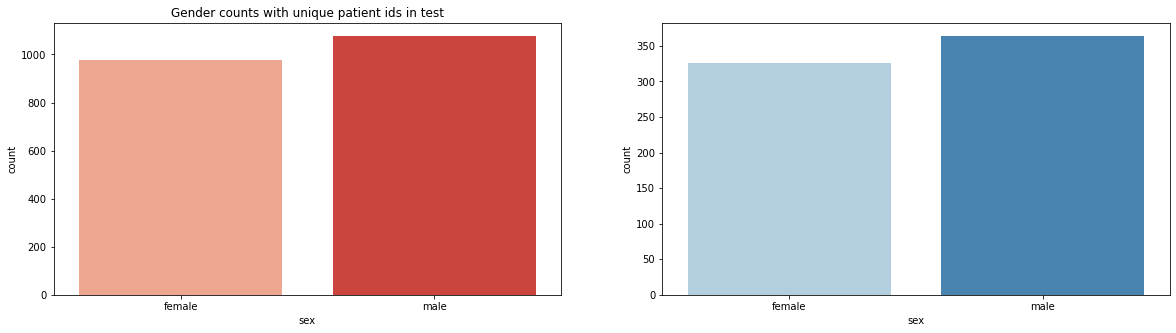

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train_patients.sex, ax=ax[0], palette="Reds")
ax[0].set_title("Gender counts with unique patient ids in train")
sns.countplot(test_patients.sex, ax=ax[1], palette="Blues");
ax[0].set_title("Gender counts with unique patient ids in test");

*Insights*

- Even on the patient id level we have more males than females in both train and test data.

# **Preprocessing image data**

In [34]:
labels=[]
data=[]
BATCH_SIZE = 32
for i in range(df_train.shape[0]):
    data.append(train_dir + df_train['image_name'].iloc[i]+'.jpg')
    labels.append(df_train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

test_data=[]
for i in range(df_test.shape[0]):
    test_data.append(test_dir + df_test['image_name'].iloc[i]+'.jpg')
data_test=pd.DataFrame(test_data)
data_test.columns=['images']
data_test['target']=''

X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(256, 256),
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode='raw')

Found 26500 validated image filenames.
Found 6626 validated image filenames.


In [35]:
img_disp_train = train_generator[0][0]
label_disp_train = train_generator[0][1]

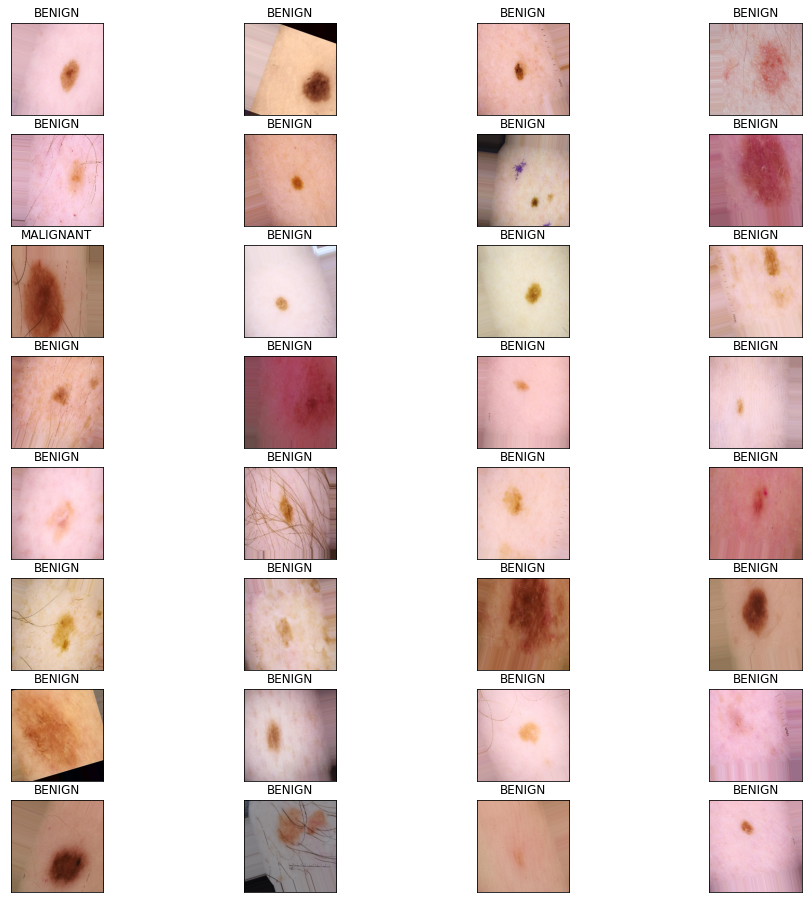

In [36]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(img_disp_train)):
    ax = fig.add_subplot(8, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img_disp_train[i]))
    if label_disp_train[i]:
       plt.title("MALIGNANT")
    else:
       plt.title("BENIGN")

In [37]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    data_test,
    x_col='images',
    y_col='target',
    target_size=(256, 256),
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode='raw')

Found 10982 validated image filenames.


# **Build model**

In [38]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                        input_shape=(256, 256, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0

In [39]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1212037111043981398
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4957477498684632660
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2275226246783100783
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1510463654295607015
physical_device_desc: "device: XLA_GPU device"
]


In [40]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
with tf.device("/device:GPU:0"):
    fit = model.fit(train_generator, steps_per_epoch=int(train.shape[0]/BATCH_SIZE), epochs=5,
                         validation_data=validation_generator, validation_steps=int(validation.shape[0]/BATCH_SIZE))

Epoch 1/5
828/828 [==============================] - 5902s 7s/step - loss: 0.0937 - accuracy: 0.9808 - val_loss: 0.0844 - val_accuracy: 0.9838
Epoch 2/5
828/828 [==============================] - 5745s 7s/step - loss: 0.0898 - accuracy: 0.9820 - val_loss: 0.0830 - val_accuracy: 0.9838
Epoch 3/5
828/828 [==============================] - 5884s 7s/step - loss: 0.0891 - accuracy: 0.9820 - val_loss: 0.0853 - val_accuracy: 0.9838
Epoch 4/5
828/828 [==============================] - 6031s 7s/step - loss: 0.0879 - accuracy: 0.9820 - val_loss: 0.0874 - val_accuracy: 0.9838
Epoch 5/5
828/828 [==============================] - 5842s 7s/step - loss: 0.0861 - accuracy: 0.9820 - val_loss: 0.0799 - val_accuracy: 0.9838


In [6]:
# save model
model.save('model.h5')

NameError: name 'model' is not defined

# **Evaluate model**

In [42]:
# metrics = list(model.history.keys())
# loss_values = model.history[metrics[2]]
# val_loss_values = model.history[metrics[0]]
# acc_values = model.history[metrics[3]]
# val_acc_values = model.history[metrics[1]]
# print("\nFinal validation loss function is", val_loss_values[-1])
# print("Final validation accuracy is", val_acc_values[-1])

# summarize history for accuracy
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'History' object has no attribute 'keys'

In [43]:
y_pred = model.predict(validation_generator)

In [44]:
y_val = validation['target'].values

In [45]:
print(classification_report(y_val, y_pred.round()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6519
           1       0.00      0.00      0.00       107

    accuracy                           0.98      6626
   macro avg       0.49      0.50      0.50      6626
weighted avg       0.97      0.98      0.98      6626



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
auc_gbc = roc_auc_score(y_val, y_pred)
print('auc: '+ str(auc_gbc))
gini_gbc = 2*auc_gbc - 1
print('gini: ' + str(gini_gbc))

auc: 0.6974709440270209
gini: 0.39494188805404185


# **Test model with data in test**

In [5]:
x_test = test_generator[0][0]

NameError: name 'test_generator' is not defined

In [48]:
y_pred = model.predict(x_test)

In [4]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(x_test)):
    ax = fig.add_subplot(8, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[i]))
    ax.set_title("{}".format(y_pred[i]))  

NameError: name 'x_test' is not defined

<Figure size 1152x1152 with 0 Axes>